# Image Regression (a light intro to Pose-Detection)

* Using a CNN to find "points"
* Usually either pose or point indentification
* Model output is any `n` pairs of points

In [0]:
import os
!pip install -q torch torchvision feather-format kornia pyarrow Pillow wandb nbdev fastprogress --upgrade 
!pip install -q git+https://github.com/fastai/fastcore  --upgrade
!pip install -q git+https://github.com/fastai/fastai2 --upgrade
os._exit(00)

# Libraries

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# Data

I have a stored google drive zip file of the Kaggle [Cats](https://www.kaggle.com/crawford/cat-dataset) dataset

In [2]:
!gdown "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"

Downloading...
From: https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM
To: /content/cat-dataset.zip
4.33GB [01:32, 46.6MB/s]


Now that it is downloaded, let's unzip using `ZipFile`

In [0]:
import zipfile
with zipfile.ZipFile('cat-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

How is the data stored? Let's take a look by walking our folders:

In [4]:
import os
[x[0] for x in os.walk('cats')]

['cats',
 'cats/CAT_02',
 'cats/CAT_05',
 'cats/CAT_03',
 'cats/CAT_01',
 'cats/CAT_04',
 'cats/CAT_06',
 'cats/CAT_00']

We can see we have duplicate folders. Let's get rid of the `CAT_` directories and work out of the `cats` folder

In [0]:
for i in range(7):
  path = Path(f'CAT_0{i}')
  shutil.rmtree(path)

Now we need to move all of the files up one level. We can use this utilizing `pathlib`

In [0]:
for i in range(7):
  paths = Path(f'cats/CAT_0{i}').ls()
  for path in paths:
    p = Path(path).absolute()
    par = p.parents[1]
    p.rename(par/p.name)

Our keypoints are available in an image's corresponding `.cat` file. We can use this to ensure we just have images for what is labelled

In [0]:
path = Path('cats')

In [0]:
lbls = get_files(path, extensions='.cat')
imgs = get_image_files(path)

Let's ensure that we have all of the files we need

In [0]:
test_eq(len(lbls), len(imgs))

And now let's work to visualizing our data. First we need a way to grab our label based on a filename

In [0]:
def img2kpts(f): return f'{str(f)}.cat'

Let's test this out by grabing an image

In [0]:
fname = imgs[1]

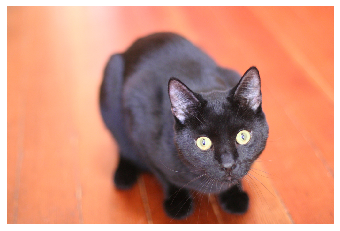

In [12]:
img = PILImage.create(fname); img.show()

Now let's grab the coordinates!

In [13]:
kpts = np.genfromtxt(img2kpts(fname)); kpts

array([  9., 616., 429., 739., 410., 695., 522., 536., 370., 514., 225.,
       608., 306., 708., 295., 775., 190., 793., 335.])

* The number of points by default are 9
  * Left Eye
  * Right Eye
  * Mouth
  * Left Ear-1
  * Left Ear-2
  * Left Ear-3
  * Right Ear-1
  * Right Ear-2 
  * Right Ear-3

Which means we can seperate our keypoints to pairs

In [23]:
kpts

array([  9., 616., 429., 739., 410., 695., 522., 536., 370., 514., 225.,
       608., 306., 708., 295., 775., 190., 793., 335.])

In [0]:
def sep_points(coords:array):
  "Seperates array of points into keypoints"
  kpts = []
  for i in range(1, int(coords[0]*2), 2):
    kpts.append([coords[i], coords[i+1]])
  return tensor(kpts)

In [27]:
pnts = sep_points(kpts); pnts

tensor([[616., 429.],
        [739., 410.],
        [695., 522.],
        [536., 370.],
        [514., 225.],
        [608., 306.],
        [708., 295.],
        [775., 190.],
        [793., 335.]])

Great! Let's see how it all looks together. We need a function to grab some `TensorPoints`

First let's make a simple `get_y` to perform all of that above

In [0]:
def get_y(f:Path):
  "Get keypoints for an image"
  pts = np.genfromtxt(img2kpts(f))
  return sep_points(pts)

And now let's get our `TensorPoints` to show an example

In [0]:
def get_ip(img:PILImage, pts:array): return TensorPoint(pts, sz=img.size)

In [45]:
ip = get_y(fname); ip

tensor([[616., 429.],
        [739., 410.],
        [695., 522.],
        [536., 370.],
        [514., 225.],
        [608., 306.],
        [708., 295.],
        [775., 190.],
        [793., 335.]])

In [0]:
tp = get_ip(img, ip)

Now to visualize our points, we pass in an axis to a `show` method and it will overlay our points to the image!

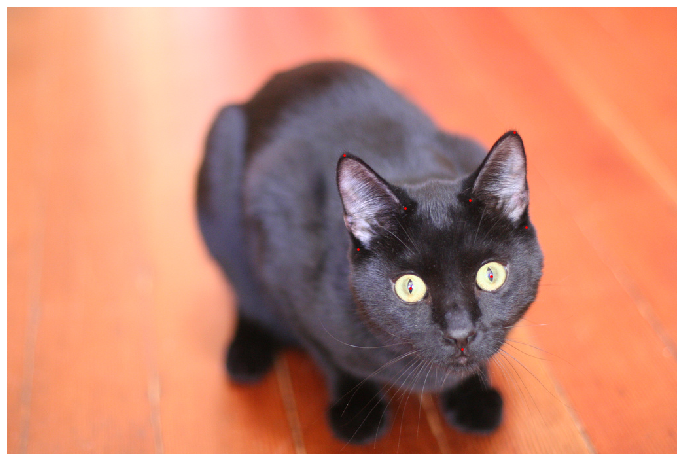

In [47]:
ax = img.show(figsize=(12,12))
tp.show(ctx=ax)

Awesome! We have all the bits we need, now let's `DataBlock` it

In [0]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y)

In [0]:
bs=48

With our `get_y` how it is, we'll want a base path of `''`

In [0]:
path = Path('')

In [0]:
dbunch = dblock.databunch(path, path=path, item_tfms=Resize(224), bs=bs,
                batch_tfms=[Normalize.from_stats(*imagenet_stats)])

Let's take a look!

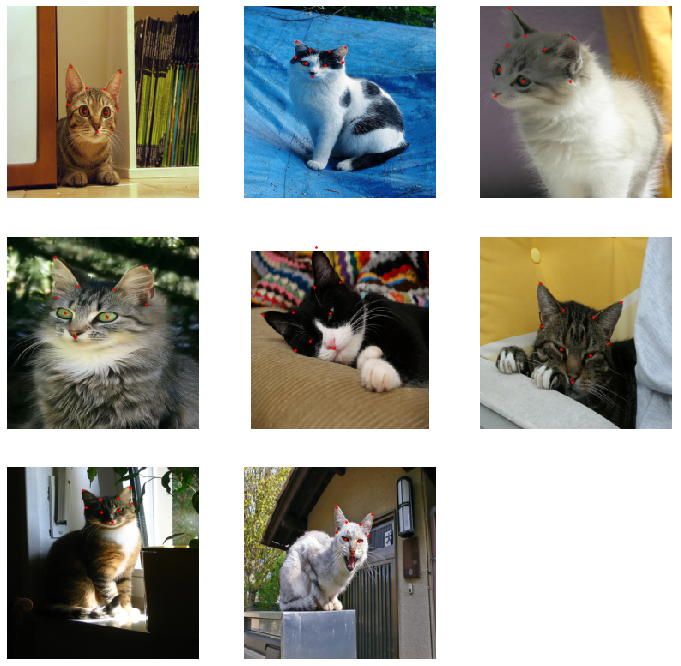

In [52]:
dbunch.show_batch(max_n=8, figsize=(12,12))

Awesome! Now let's give a `.c` attribute so we can make our model easier

In [0]:
dbunch.c = dbunch.train_dl.after_item.c

Now let's go through and generate a custom model and head for regression, but how do we do this?

If we know our outputs and inputs, we can make use of two functions, `create_body`, and `create_head`. `create_body` will chop the top of our pre-trained model for us, and `create_head` will make a special fastai configured head that has shown to work better. What will we need?

* Outputs: 18 (9 pairs of points)
* Inputs: 1024 filter (ResNet34)

In [54]:
head = create_head(1024, 18); head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=18, bias=False)
)

Now let's grab our body

In [55]:
body = create_body(resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 12.0MB/s]


And finally wrap them together

In [0]:
arch = nn.Sequential(body, head)

Now we want discrimitive learning rates, so we need to define what this looks like. Here is it for a resnet split:

In [0]:
def  _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)

Finally, we'll want to create a loss function along with a few custom metrics to keep track of our keypoint progression. With our loss function, we will examine our output keypoints, grab the relative distance, and sum them together

In [0]:
def myLoss(out, pts):
  loss = 0
  for p in range(len(out)):
    pred = out[p].view(-1, 2)
    loss += F.mse_loss(pred, pts[p])
  return loss

And now for some custom metrics.

In [0]:
def left_eye(inp, targ):
  inp = inp[0].view(-1, 2)
  targ = targ[0]
  return F.mse_loss(*flatten_check(inp, targ))

def right_eye(inp, targ):
  inp = inp[1].view(-1, 2)
  targ = targ[1]
  return F.mse_loss(*flatten_check(inp, targ))

def mouth(inp, targ):
  inp = inp[2].view(-1, 2)
  targ = targ[2]
  return F.mse_loss(*flatten_check(inp, targ))

def l_ear(inp,targ):
  inp = inp[3:5].view(-1,2)
  targ = targ[3:5]
  return F.mse_loss(*flatten_check(inp, targ))

def r_ear(inp, targ):
  inp = inp[6:]
  targ = targ[6:]
  return F.mse_loss(*flatten_check(inp, targ))

In [0]:
metrics = [left_eye, right_eye, mouth, l_ear, r_ear]

Now that we have all the pieces, let's make a model!

In [0]:
learn = Learner(dbunch, arch, splitter=_resnet_split, loss_func=myLoss, metrics=metrics,
                opt_func=ranger)

Freeze our model now at our split

In [0]:
learn.freeze()

And initialize our custom head

In [0]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

Now we can find a learning rate and fit our model!

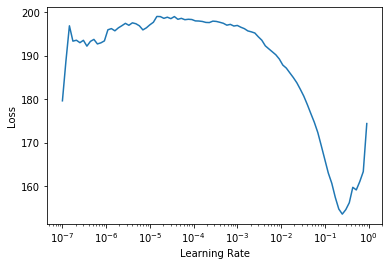

In [65]:
learn.lr_find()

In [73]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,left_eye,right_eye,mouth,l_ear,r_ear,time
0,4.930614,1.133250,0.014659,0.017754,0.017570,0.017412,0.015758,01:49
1,1.140884,0.810304,0.008943,0.013529,0.013941,0.011366,0.011318,01:50
2,0.987757,0.653342,0.007634,0.009188,0.010718,0.010821,0.009105,01:48
3,0.742759,0.817586,0.007856,0.010845,0.008514,0.009723,0.011598,01:48
4,0.505309,0.481872,0.005662,0.008199,0.004916,0.006116,0.006814,01:47


Let's see how five epochs winds up doing

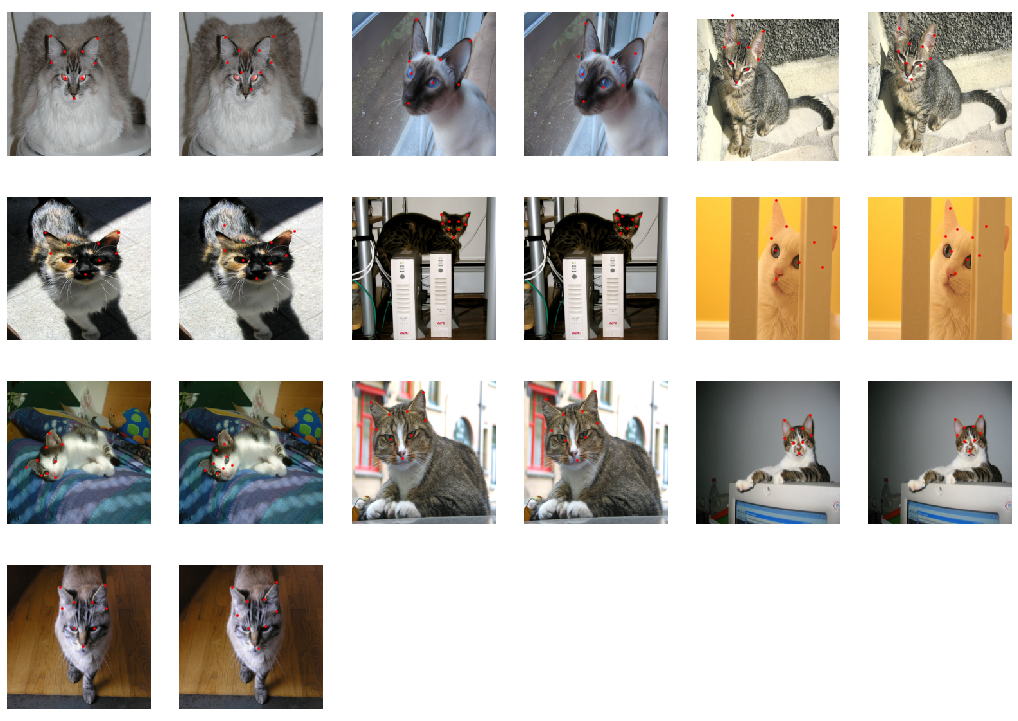

In [74]:
learn.show_results()

Pretty good for only five epochs! Let's train for a few more

In [0]:
learn.save('stage_1')

In [76]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,left_eye,right_eye,mouth,l_ear,r_ear,time
0,0.609849,0.558733,0.005445,0.010142,0.007952,0.008950,0.007850,01:47
1,0.519050,0.531460,0.006520,0.005325,0.007956,0.009080,0.007442,01:47
2,0.519237,0.670528,0.008940,0.008886,0.007155,0.011193,0.009414,01:47
3,0.481806,0.430979,0.005246,0.005055,0.005958,0.007413,0.006079,01:47
4,0.376993,0.347206,0.004286,0.005078,0.003989,0.005760,0.004878,01:47


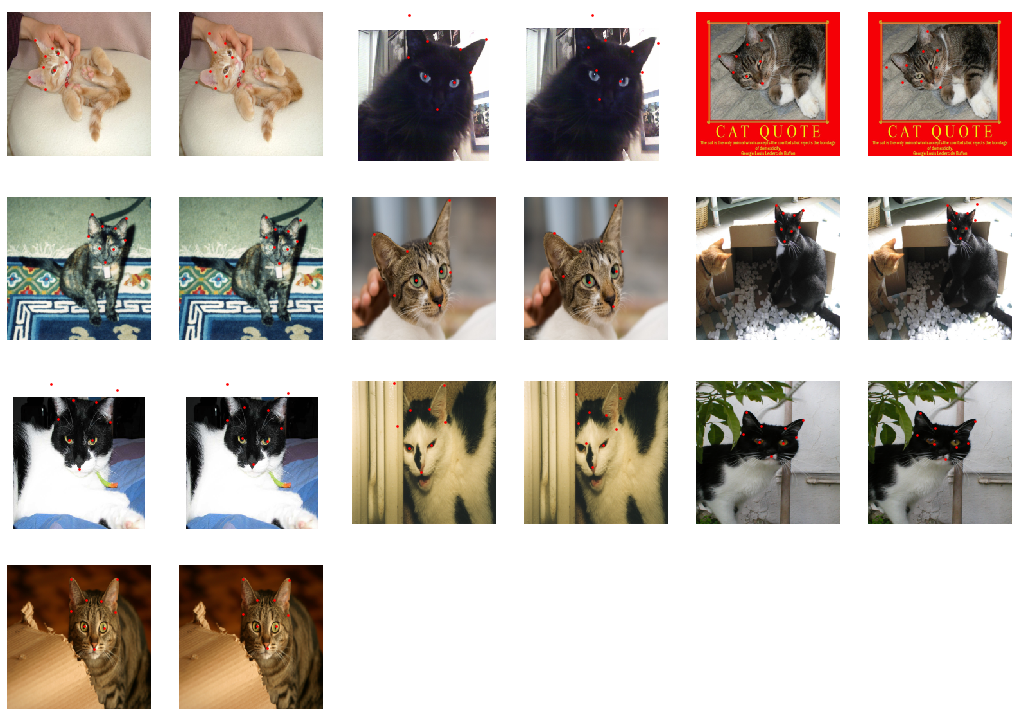

In [77]:
learn.show_results()